In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import engine
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conn_string = r"postgresql://masterschool-analyst:pa84cc0d01e9b241460abdf838bb34f5932c9473dca571b56fcb13dd3023a62e0@ec2-52-4-84-108.compute-1.amazonaws.com:5432/da541q56oobji4"
connection = engine.create_engine(conn_string)

In [3]:
query = """select * from mat_orders"""

df = pd.read_sql(query, con=conn_string)

In [4]:
cte_query = """
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
    AND created_at < '2023-07-01'
;

"""

filtered_df = pd.read_sql(cte_query, con=conn_string)

<Axes: title={'center': 'Mean final price per operator distribution'}>

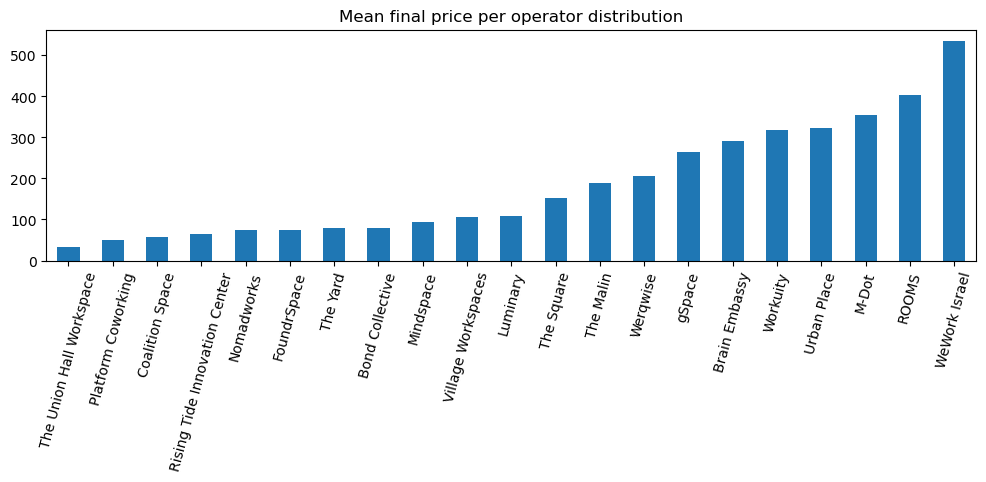

In [5]:
filtered_df.groupby('operator_name').mean(numeric_only=True)['final_price'].sort_values().plot(kind="bar", xlabel="", 
                                                                              rot=75,
                                                                              figsize=(12,3),
                                                                              title="Mean final price per operator distribution")

In [6]:
filtered_df.groupby('operator_name').sum(numeric_only=True)['final_price'].sort_values(ascending=False)


operator_name
WeWork Israel                    2279715.41
Mindspace                         862476.67
The Yard                          269103.00
The Malin                         256210.25
Urban Place                       201909.38
Brain Embassy                     176435.66
Werqwise                          115175.50
ROOMS                             105019.20
Luminary                           84839.75
Nomadworks                         69556.50
M-Dot                              35695.53
Bond Collective                    30043.75
FoundrSpace                        10972.50
Village Workspaces                  7271.60
gSpace                              1850.00
Rising Tide Innovation Center       1847.50
Workuity                             950.00
Platform Coworking                   815.00
The Square                           760.00
Coalition Space                      455.00
The Union Hall Workspace             395.00
Name: final_price, dtype: float64

In [7]:
# Extracting just the date from created_at as date
filtered_df['date'] = filtered_df['created_at'].dt.date

filtered_df['date'].count()


22695

In [8]:
# Number of unique operators
filtered_df['operator_id'].nunique()


21

In [9]:
fdf = filtered_df

# Features 

In [10]:
# Convert 'date' to a time stamp
fdf['date'] = pd.to_datetime(fdf['date'])

monetary_for_preperation = fdf.groupby(['operator_id', 'customer_email','date'], as_index=False)['final_price'].sum()
interim_fdf = fdf.sort_values(['operator_id', 'customer_email','created_at']).drop_duplicates(['operator_id', 'customer_email','date'])
interim_fdf = interim_fdf.drop('final_price', axis=1)

### Monetary value per country

In [11]:
fdf = interim_fdf.merge(monetary_for_preperation).copy()

In [12]:
country_totals = pd.DataFrame(fdf.groupby('country', as_index = False)['final_price_usd'].sum(numeric_only=True))

country_totals = country_totals.sort_values(by='final_price_usd', ascending=False).reset_index(drop=True)

country_totals


,country,final_price_usd
0,US,868369.54
1,IL,741107.85
2,DE,340773.58
3,GB,125481.03
4,NL,63256.89
5,PL,36958.07
6,RO,24499.01


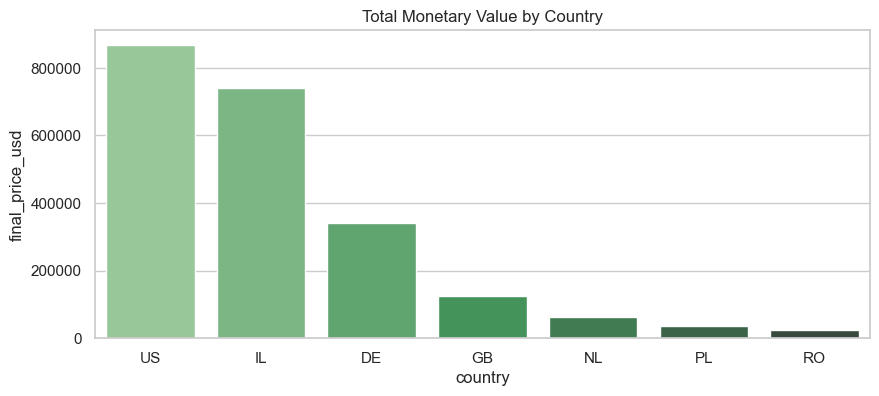

In [13]:
# Plotting country totals 
plt.figure(figsize=(10,4))

sns.set(style='whitegrid', color_codes=True)

pal = sns.color_palette('Greens_d', len(country_totals))

# Swap x and y for vertical bars
sns.barplot(x=country_totals['country'], y=country_totals['final_price_usd'], palette=pal)

plt.title('Total Monetary Value by Country')
plt.xticks()
plt.show()

### Number of operators in each country 

In [14]:
country_operator = pd.DataFrame(fdf.groupby('country', as_index = False)['operator_name'].nunique()).sort_values(by='operator_name', ascending=False).reset_index(drop=True)

country_operator 

,country,operator_name
0,US,16
1,IL,6
2,PL,2
3,DE,1
4,GB,1
5,NL,1
6,RO,1


Text(0.5, 1.0, 'Operators in each Country')

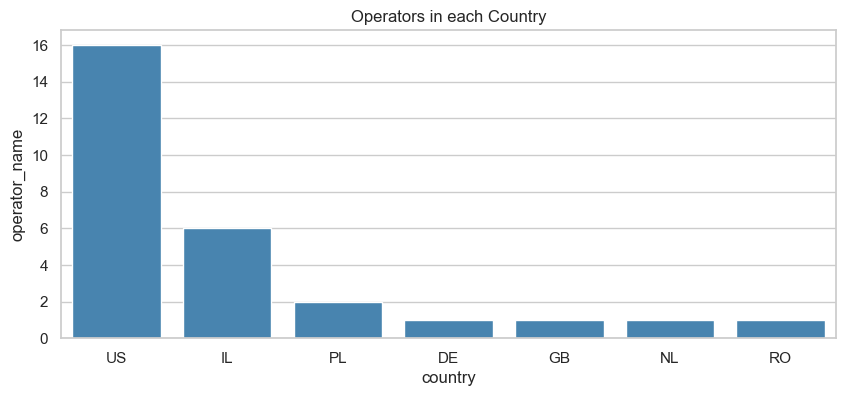

In [15]:
plt.figure(figsize = (10, 4))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Blues_d", 1)

sns.barplot(x=country_operator['country'], y=country_operator['operator_name'], palette=pal)

plt.title('Operators in each Country')

### Time series  

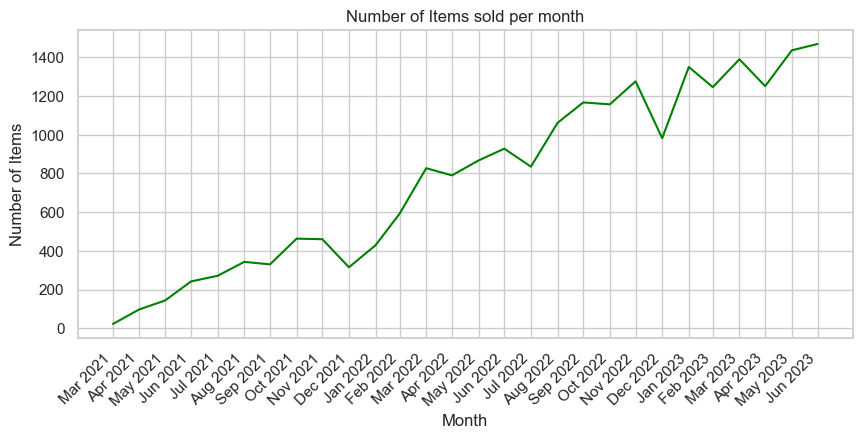

In [16]:
df_group = pd.DataFrame(fdf.resample('M', on='date')['order_id'].count())
df_group.columns = ['Number_of_items_sold']
    
plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group.index, y=df_group['Number_of_items_sold'], color = 'Green')

plt.title('Number of Items sold per month')
plt.xlabel('Month')
plt.ylabel('Number of Items')

plt.xticks(df_group.index, df_group.index.strftime('%b %Y'), rotation=45, ha='right')
plt.show()

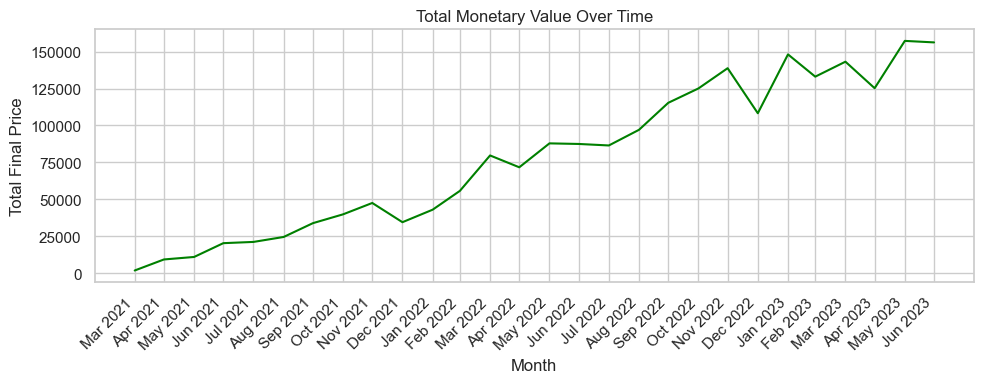

In [17]:
df_group = fdf.resample('M', on='date')['final_price_usd'].sum()
df_group = df_group.reset_index()
df_group.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group['Month'], y=df_group['Total_final_price'], color = 'Green')

plt.title('Total Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(df_group['Month'], df_group['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

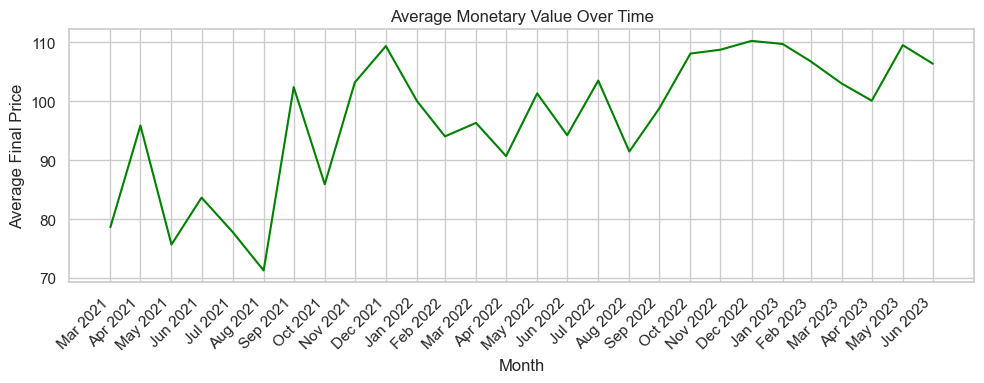

In [18]:
df_group = fdf.resample('M', on='date')['final_price_usd'].mean()
df_group = df_group.reset_index()
df_group.columns = ['Month', 'Average_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group['Month'], y=df_group['Average_final_price'], color = 'Green')

plt.title('Average Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Average Final Price')

plt.xticks(df_group['Month'], df_group['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

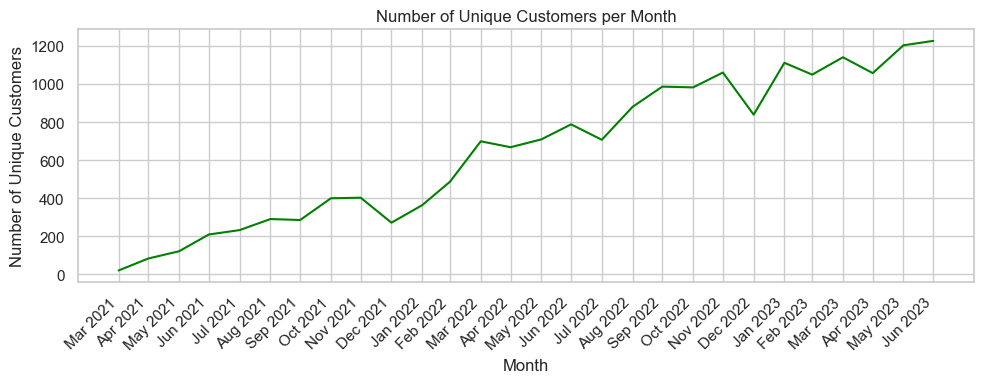

In [19]:
df_group = fdf.resample('M', on='date').customer_email.nunique()
df_group = df_group.reset_index()
df_group.columns = ['Month', 'Number_of_unique_customers']

plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group['Month'], y=df_group['Number_of_unique_customers'], color = 'Green')

plt.title('Number of Unique Customers per Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Customers')

plt.xticks(df_group['Month'], df_group['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# RFM Function

Operator by Full Name + Space Name 

In [20]:
fdf['operator_key'] = fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']
fdf['operator_full_name'] = fdf['operator_name']+"-"+fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']+"-"+fdf['space_name']

pivot_table = fdf.groupby(['operator_name', 'operator_key']).size().unstack(fill_value=0)

# pivot_table.astype(bool).sum(axis=1).sort_values(ascending=False)

In [21]:
def create_extended_rfm_by(fdf_, key="operator_name"):

    # this is a bogus filter - you can change that however you like
    fdf_filtered = fdf_[fdf_['date'] < pd.to_datetime('2023-07-01')].copy()
    
    #recency and lifetime
    df_recency = fdf_filtered.groupby(key)['date'].agg(["max", "min"]).reset_index()
    df_recency.columns = ['operator', 'last_order', "first_order"]
    
    df_recency['recency'] = (pd.Timestamp.now().normalize() - df_recency['last_order']).dt.days
    df_recency['lifetime'] = (df_recency['last_order'] - df_recency['first_order']).dt.days+1
    
    #monetary and frequency 
    df_monetary_freq = fdf_filtered.groupby(key)['final_price_usd'].agg(['count', sum]).copy().reset_index()
    df_monetary_freq.columns = ['operator', 'frequency', "monetary"]

    
    # Count number of orders for each customer and partner
    df_orders = fdf_filtered.groupby([key, 'customer_email']).size().reset_index(name='orders')
    # Calculate whether the customer has returned (1 if 'orders' > 1, 0 otherwise)
    df_orders['returned'] = (df_orders['orders'] > 1).astype(int)

    # Now group by partner_name and calculate total customers and returning customers
    df_final = df_orders.groupby(key).agg(total_customers=('customer_email', 'count'), returning_customers=('returned', 'sum')).reset_index()
    df_final['return_rate'] = df_final['returning_customers'] / df_final['total_customers']
    #df_final = df_final.drop(['returning_customers', 'total_customers'], axis=1).copy()
    df_final.columns = ['operator', "total_customers", "returning_customers", "return_rate"]
    
    df = df_recency.merge(df_monetary_freq).merge(df_final).copy()
    df = df.drop(['last_order','first_order','returning_customers'], axis=1)
    df['intensity'] = df['frequency']/df['lifetime']
    return df

In [22]:
rfm_by_operator_name = create_extended_rfm_by(fdf)
rfm_by_full_name = create_extended_rfm_by(fdf, key="operator_full_name")

In [23]:
rfm_by_full_name.head()

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
0,Bond Collective-US-CA-Los Angeles-Bond Collect...,48,85,19,725.0,18,0.055556,0.223529
1,Bond Collective-US-CA-Los Angeles-Rialto,56,34,2,637.5,2,0.000000,0.058824
2,Bond Collective-US-DC-Washington-Bond Collecti...,119,9,5,125.0,3,0.666667,0.555556
3,Bond Collective-US-IL-Chicago-Bond Collective ...,45,91,32,2150.0,31,0.032258,0.351648
4,Bond Collective-US-IL-Chicago-Haymarket,123,1,1,300.0,1,0.000000,1.000000


In [24]:
rfm_by_full_name.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,127.388560,243.047337,42.865878,4340.130118,30.461538,0.155482,0.276257
std,113.791853,222.805233,154.547439,11541.735665,107.700691,0.228303,0.423969
min,45.000000,1.000000,1.000000,22.340000,1.000000,0.000000,0.003945
25%,53.000000,34.500000,2.000000,407.455000,2.000000,0.000000,0.030303
50%,76.000000,191.000000,6.000000,1140.000000,5.000000,0.083333,0.061041
75%,161.000000,398.000000,17.000000,3117.595000,13.000000,0.214286,0.298739
max,700.000000,837.000000,2227.000000,143816.500000,1585.000000,1.000000,4.154851


# Segmentation

In [25]:
def segment_customer(row):
    if row['lifetime'] < 90:
        return 'new'
    elif row['recency'] > 157:
        return 'churned'
    elif row['lifetime'] < 400 and row['monetary'] < 100000:
        return 'still young'
    elif row['lifetime'] >= 400 and row['monetary'] < 100000:
        return 'loyalist'
    elif row['monetary'] >= 100000:
        return 'big_fish'
    else:
        return 'other'

rfm_by_full_name['seg'] = rfm_by_full_name.apply(segment_customer, axis=1)

In [26]:
rfm_by_full_name['seg'].unique()

array(['new', 'still young', 'churned', 'loyalist', 'big_fish'],
      dtype=object)

In [30]:
rfm_by_full_name['seg'].value_counts(sort=False)

new            175
still young    156
churned         64
loyalist       111
big_fish         1
Name: seg, dtype: int64

In [31]:
seg_merge_fdf = fdf.merge(rfm_by_full_name[['operator', 'seg']], 
                       left_on='operator_full_name', 
                       right_on='operator')


In [38]:
big_fish_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'big_fish']
loyalist_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'loyalist']
still_young_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'still young']
new_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'new']
churned_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'churned']


In [39]:
big_fish_monetary = big_fish_fdf[['date', 'final_price_usd']]
loyalist_monetary = loyalist_fdf[['date', 'final_price_usd']]
still_young_monetary = still_young_fdf[['date', 'final_price_usd']]


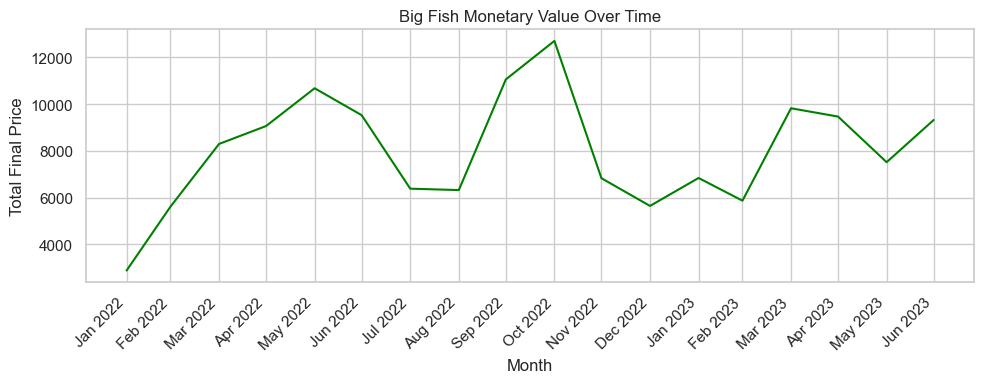

In [40]:
big_fish_monetary = big_fish_monetary.resample('M', on='date')['final_price_usd'].sum()
big_fish_monetary = big_fish_monetary.reset_index()
big_fish_monetary.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=big_fish_monetary['Month'], y=big_fish_monetary['Total_final_price'], color = 'Green')

plt.title('Big Fish Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(big_fish_monetary['Month'], big_fish_monetary['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

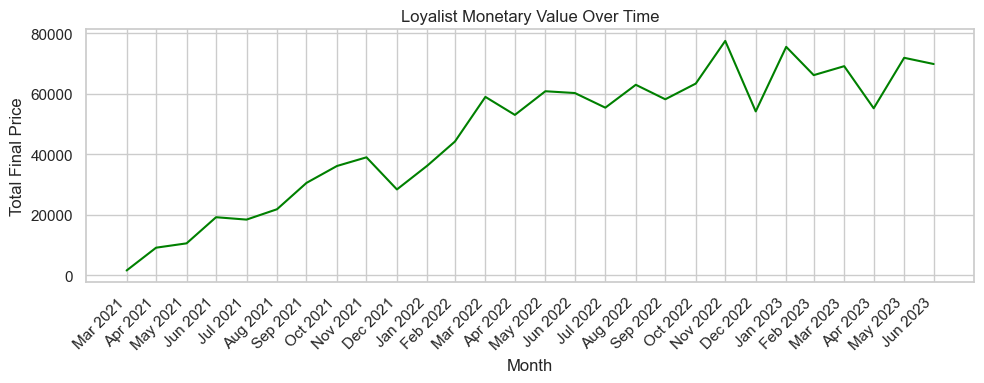

In [41]:
loyalist_monetary = loyalist_monetary.resample('M', on='date')['final_price_usd'].sum()
loyalist_monetary = loyalist_monetary.reset_index()
loyalist_monetary.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=loyalist_monetary['Month'], y=loyalist_monetary['Total_final_price'], color = 'Green')

plt.title('Loyalist Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(loyalist_monetary['Month'], loyalist_monetary['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

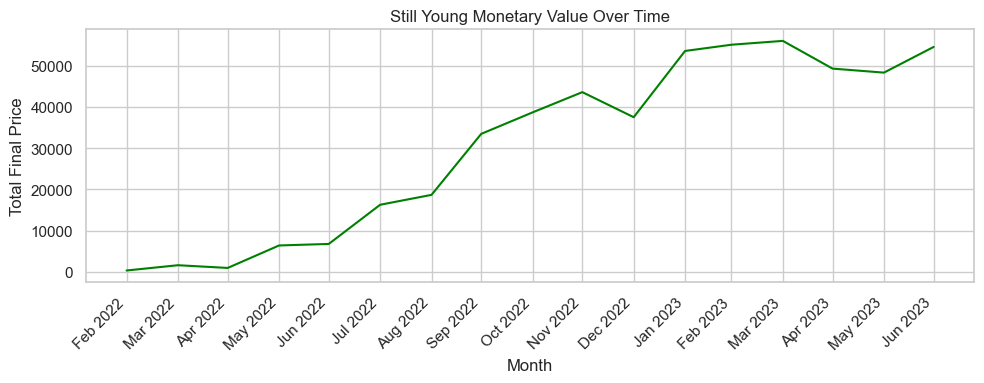

In [42]:
still_young_monetary = still_young_monetary.resample('M', on='date')['final_price_usd'].sum()
still_young_monetary = still_young_monetary.reset_index()
still_young_monetary.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=still_young_monetary['Month'], y=still_young_monetary['Total_final_price'], color = 'Green')

plt.title('Still Young Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(still_young_monetary['Month'], still_young_monetary['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

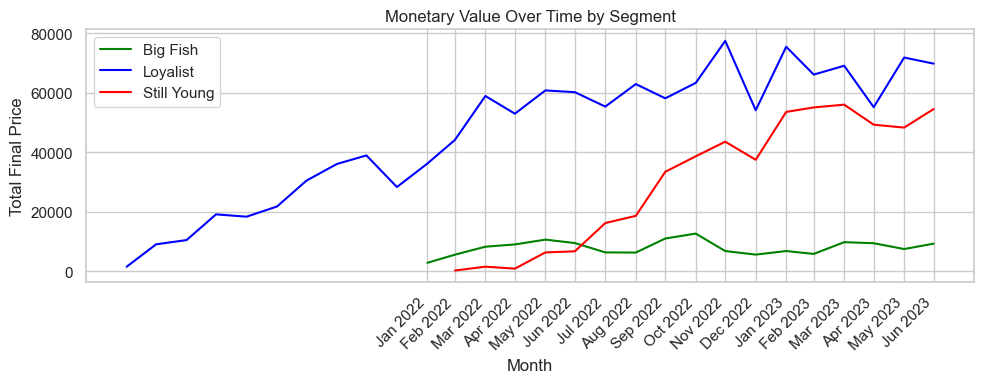

In [43]:
plt.figure(figsize=(10, 4))

sns.lineplot(x=big_fish_monetary['Month'], y=big_fish_monetary['Total_final_price'], label='Big Fish', color='Green')

sns.lineplot(x=loyalist_monetary['Month'], y=loyalist_monetary['Total_final_price'], label='Loyalist', color='Blue')

sns.lineplot(x=still_young_monetary['Month'], y=still_young_monetary['Total_final_price'], label='Still Young', color='Red')

plt.title('Monetary Value Over Time by Segment')
plt.xlabel('Month')
plt.ylabel('Total Final Price')
plt.xticks(big_fish_monetary['Month'], big_fish_monetary['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
big_fish_frequency = big_fish_fdf[['date', 'operator_full_name']]
loyalist_frequency = loyalist_fdf[['date', 'operator_full_name']]
still_young_frequency = still_young_fdf[['date', 'operator_full_name']]

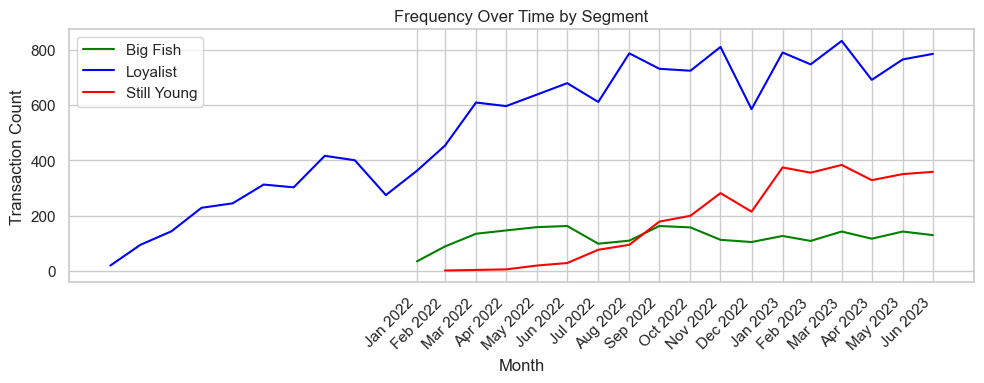

In [47]:
big_fish_freq = big_fish_frequency.resample('M', on='date')['operator_full_name'].size().reset_index(name='Frequency')
loyalist_freq = loyalist_frequency.resample('M', on='date')['operator_full_name'].size().reset_index(name='Frequency')
still_young_freq = still_young_frequency.resample('M', on='date')['operator_full_name'].size().reset_index(name='Frequency')

# Set up the figure and axis
plt.figure(figsize=(10, 4))

# Big Fish segment frequency
sns.lineplot(x=big_fish_freq['date'], y=big_fish_freq['Frequency'], label='Big Fish', color='Green')

# Loyalist segment frequency
sns.lineplot(x=loyalist_freq['date'], y=loyalist_freq['Frequency'], label='Loyalist', color='Blue')

# Not Blooming segment frequency
sns.lineplot(x=still_young_freq['date'], y=still_young_freq['Frequency'], label='Still Young', color='Red')

# Set the chart title, axis labels, and other aesthetics
plt.title('Frequency Over Time by Segment')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.xticks(big_fish_freq['date'], big_fish_freq['date'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.legend()  # Display the legend
plt.tight_layout()
plt.show()



In [60]:
def filter_by_segments(df, segments=["new", "churned", "big_fish", "loyalist", "still young"]):
    segment_dataframes = {}
    for segment in segments:
        segment_dataframes[segment] = df[df['seg'] == segment].copy()
    return segment_dataframes

segmented_rfms = filter_by_segments(rfm_by_full_name)

new_rfm = segmented_rfms['new']
churned_rfm = segmented_rfms['churned']
big_fish_rfm = segmented_rfms['big_fish']
loyalist_rfm = segmented_rfms['loyalist']
still_young_rfm = segmented_rfms['still young']


In [61]:
from sklearn.preprocessing import MinMaxScaler

metrics = ['recency','lifetime', 'frequency', 'monetary', 'total_customers', 'return_rate', 'intensity']

# Normalize the data
scaler = MinMaxScaler()
new_rfm_normalized = pd.DataFrame(scaler.fit_transform(new_rfm[metrics]), columns=metrics)
churned_rfm_normalized = pd.DataFrame(scaler.fit_transform(churned_rfm[metrics]), columns=metrics)
big_fish_rfm_normalized = pd.DataFrame(scaler.fit_transform(big_fish_rfm[metrics]), columns=metrics)
loyalist_rfm_normalized = pd.DataFrame(scaler.fit_transform(loyalist_rfm[metrics]), columns=metrics)
still_young_rfm_normalized = pd.DataFrame(scaler.fit_transform(still_young_rfm[metrics]), columns=metrics)

# Calculate means
new_mean = new_rfm_normalized.mean()
churned_mean = churned_rfm_normalized.mean()
big_fish_mean = big_fish_rfm_normalized.mean()
loyalist_mean = loyalist_rfm_normalized.mean()
still_young_mean = still_young_rfm_normalized.mean()

In [63]:
df_means = pd.DataFrame({
    'segment': ['new', 'churned', 'big_fish', 'loyalists', 'still young'],
    'recency': [new_mean['recency'], churned_mean['recency'], big_fish_mean['recency'], loyalist_mean['recency'], still_young_mean['recency']],
    'lifetime': [new_mean['lifetime'], churned_mean['lifetime'], big_fish_mean['lifetime'], loyalist_mean['lifetime'], still_young_mean['lifetime']],
    'frequency': [new_mean['frequency'], churned_mean['frequency'], big_fish_mean['frequency'], loyalist_mean['frequency'], still_young_mean['frequency']],
    'monetary': [new_mean['monetary'], churned_mean['monetary'], big_fish_mean['monetary'], loyalist_mean['monetary'], still_young_mean['monetary']],
    'total_customers': [new_mean['total_customers'], churned_mean['total_customers'], big_fish_mean['total_customers'], loyalist_mean['total_customers'], still_young_mean['total_customers']],
    'return_rate': [new_mean['return_rate'], churned_mean['return_rate'], big_fish_mean['return_rate'], loyalist_mean['return_rate'], still_young_mean['return_rate']],
    'intensity': [new_mean['intensity'], churned_mean['intensity'], big_fish_mean['intensity'], loyalist_mean['intensity'], still_young_mean['intensity']]
})

In [64]:
# Metrics and segments
metrics = ['recency', 'lifetime', 'frequency', 'monetary', 'total_customers', 'return_rate', 'intensity']
segments = ['new', 'churned', 'big_fish', 'loyalist', 'still young']

# Normalize the data
scaler = MinMaxScaler()
rfm_by_full_name_normalized = pd.DataFrame(scaler.fit_transform(rfm_by_full_name[metrics]), columns=metrics)

# Add the 'seg' column back to the normalized dataframe so you can group by it
rfm_by_full_name_normalized['seg'] = rfm_by_full_name['seg']

# Group by the 'seg' column and calculate mean for each group
segment_means = rfm_by_full_name_normalized.groupby('seg').mean()

# Filter to just the segments of interest (in case there are other segments in the 'seg' column)
segment_means = segment_means.loc[segments]



In [65]:
segment_means

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
seg,,,,,,,
new,0.187812,0.024833,0.001214,0.004043,0.001335,0.130673,0.133134
churned,0.319370,0.335395,0.006465,0.013200,0.006737,0.167516,0.011254
big_fish,0.000000,0.639952,1.000000,1.000000,1.000000,0.164038,1.000000
loyalist,0.028279,0.681549,0.058749,0.081732,0.056790,0.187465,0.047121
still young,0.046966,0.286468,0.008898,0.023072,0.009369,0.155565,0.019306


In [66]:
rfm_means = segment_means.reset_index()


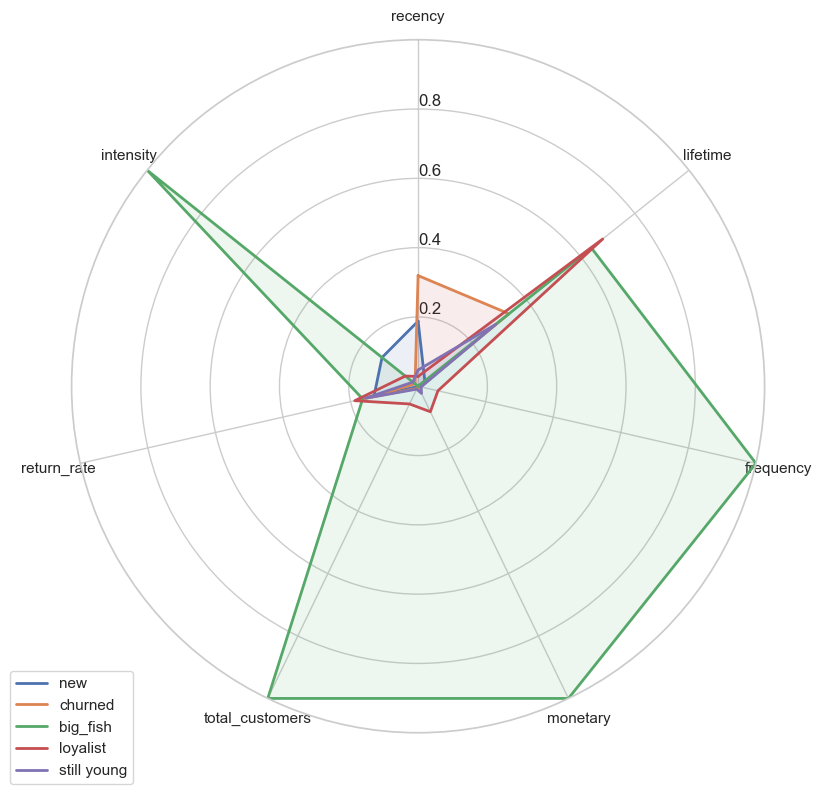

In [67]:
from math import pi

# number of variables
categories = metrics
N = len(categories)

# angles for the radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# setup the radar chart
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)


# set labels
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
yticks = [0.2, 0.4, 0.6, 0.8]
ax.set_yticks(yticks)
ax.set_yticklabels([str(y) for y in yticks], fontsize=12)
plt.ylim(0, 1)


# Plotting the data
colors = ['b', 'r', 'g', 'c', 'm']

for i, color in zip(rfm_means.index, colors):
    values = rfm_means.loc[i].drop('seg').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=rfm_means['seg'][i])
    ax.fill(angles, values, color, alpha=0.1)

# add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()


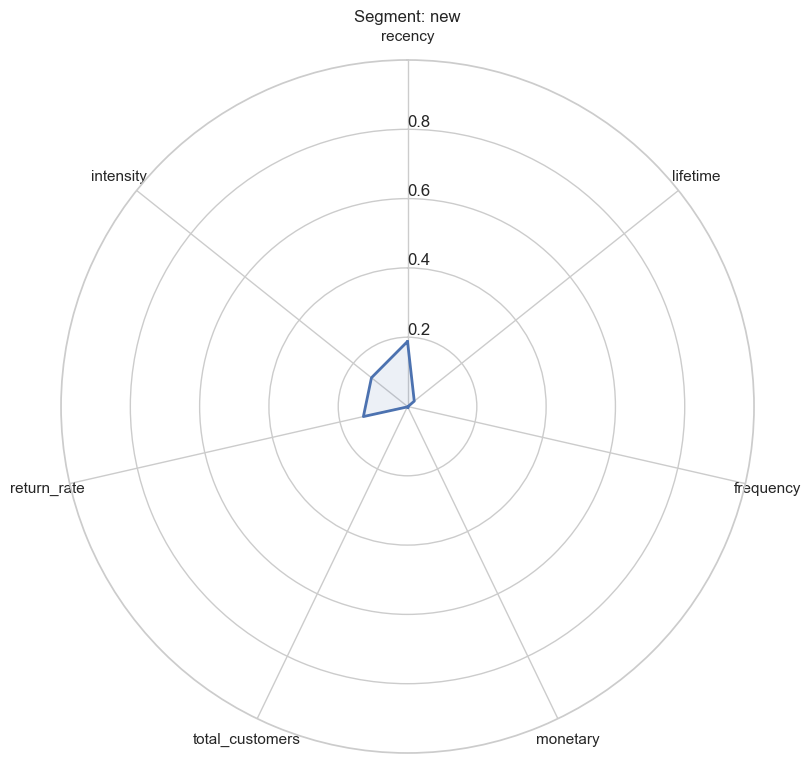

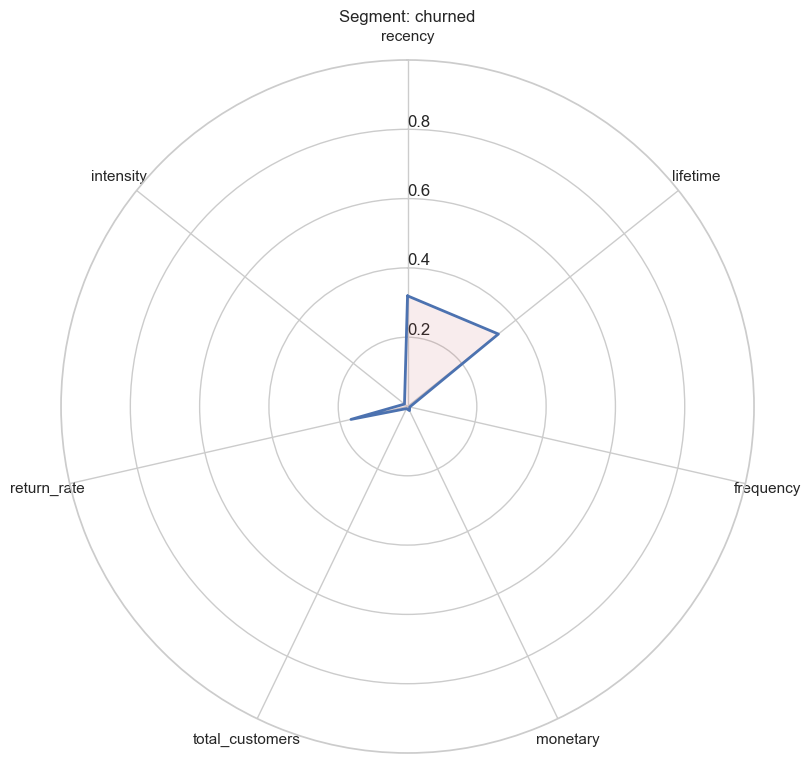

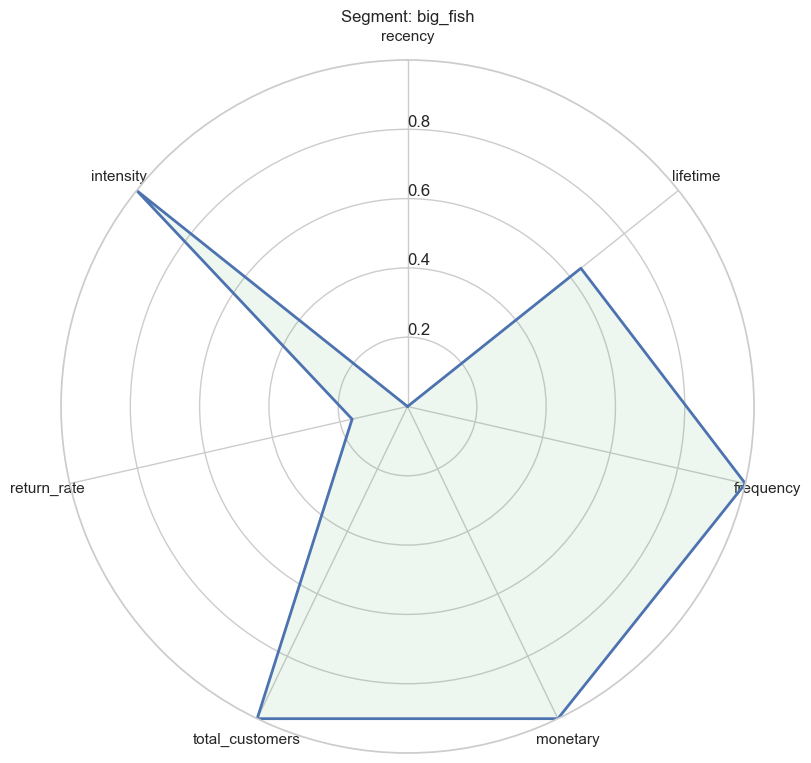

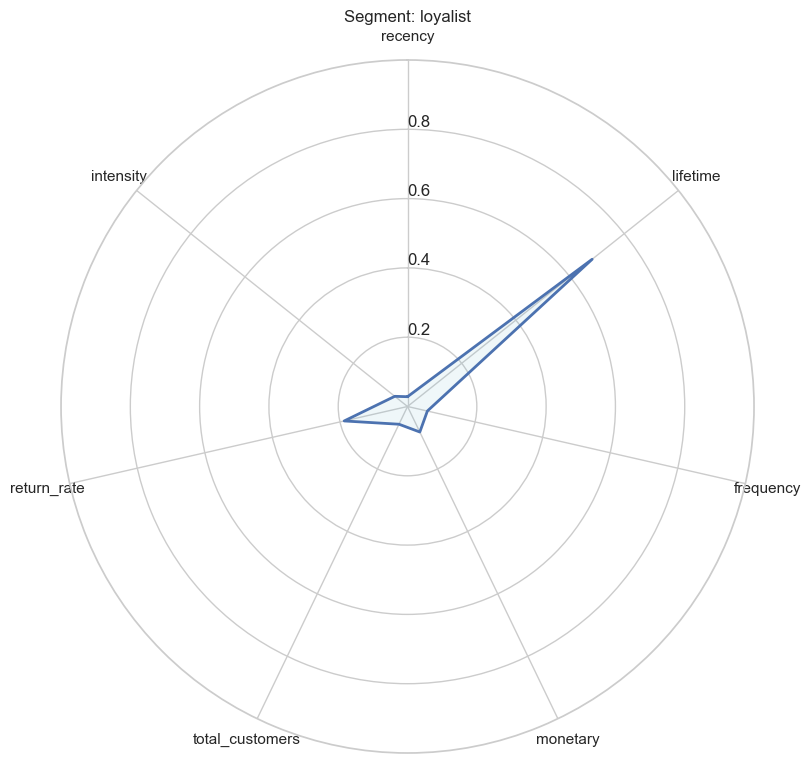

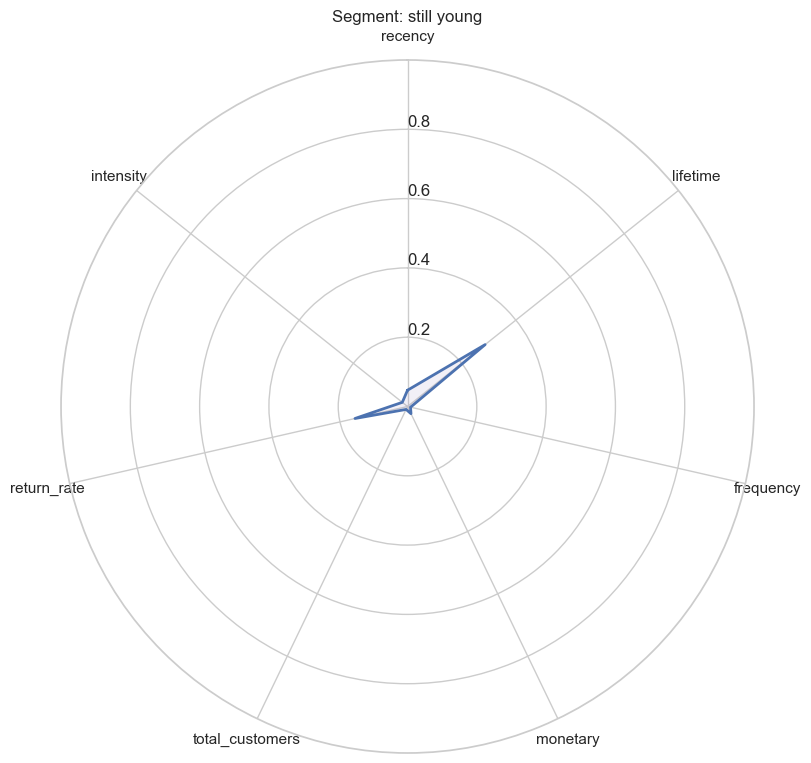

In [68]:
# number of variables
categories = metrics
N = len(categories)

# angles for the radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Setup the radar chart settings
fig_size = (9, 9)

# Initialize yticks for the radar chart
yticks = [0.2, 0.4, 0.6, 0.8]

colors = ['b', 'r', 'g', 'c', 'm']

for i, color in zip(rfm_means.index, colors):
    fig, ax = plt.subplots(figsize=fig_size, subplot_kw=dict(polar=True))
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    ax.set_yticks(yticks)
    ax.set_yticklabels([str(y) for y in yticks], fontsize=12)
    plt.ylim(0, 1)
    
    # Plotting the data for the specific segment
    values = rfm_means.loc[i].drop('seg').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=rfm_means['seg'][i])
    ax.fill(angles, values, color, alpha=0.1)
    
    # Title
    plt.title(f"Segment: {rfm_means['seg'][i]}")
    
    # Show the graph
    plt.show()


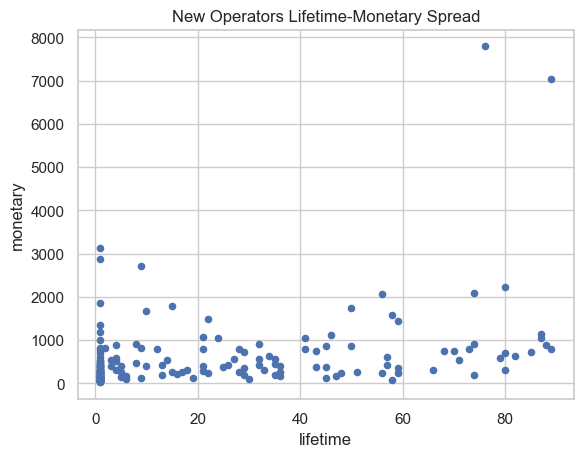

In [69]:
new_rfm[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "New Operators Lifetime-Monetary Spread");
                                                     

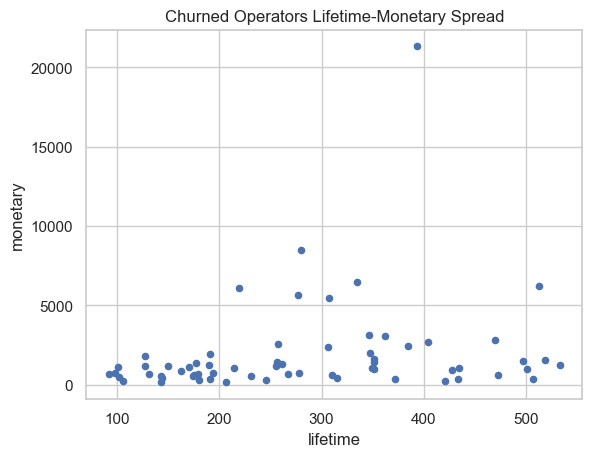

In [70]:
churned_rfm[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Churned Operators Lifetime-Monetary Spread");


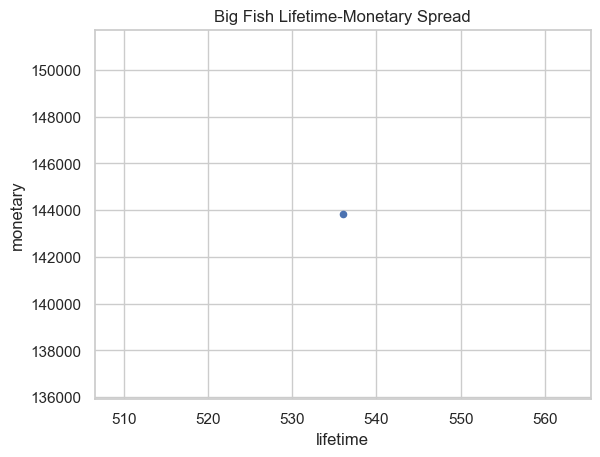

In [71]:
big_fish_rfm[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Big Fish Lifetime-Monetary Spread");


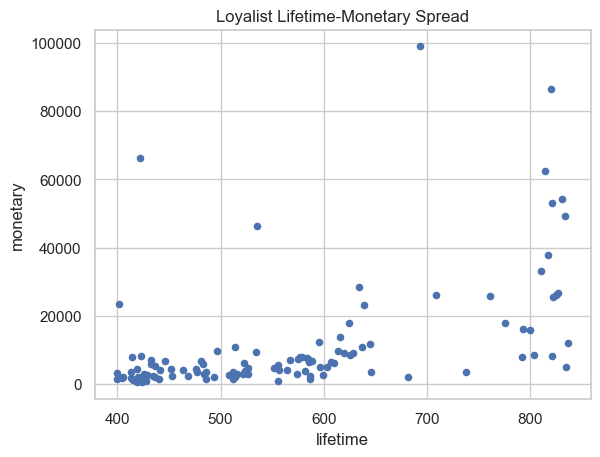

In [72]:
loyalist_rfm[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Loyalist Lifetime-Monetary Spread");


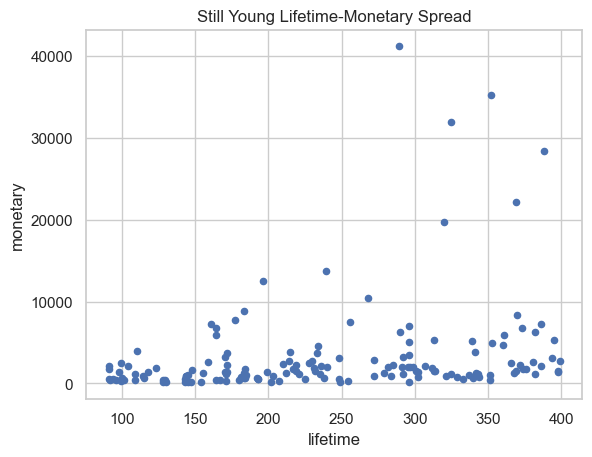

In [75]:
still_young_rfm[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Still Young Lifetime-Monetary Spread");


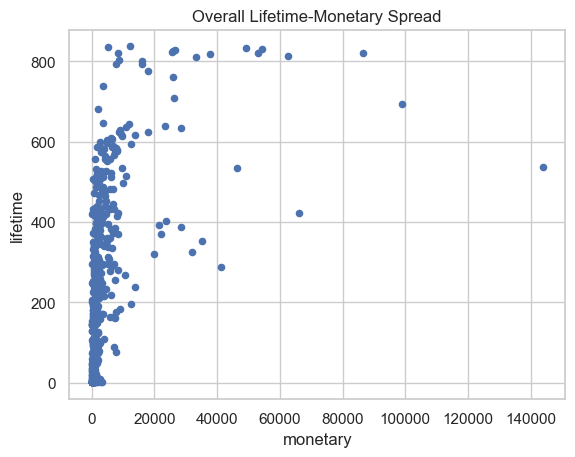

In [76]:
rfm_by_full_name[['lifetime', 'monetary']].plot(kind='scatter', x='monetary', y='lifetime', title = "Overall Lifetime-Monetary Spread");


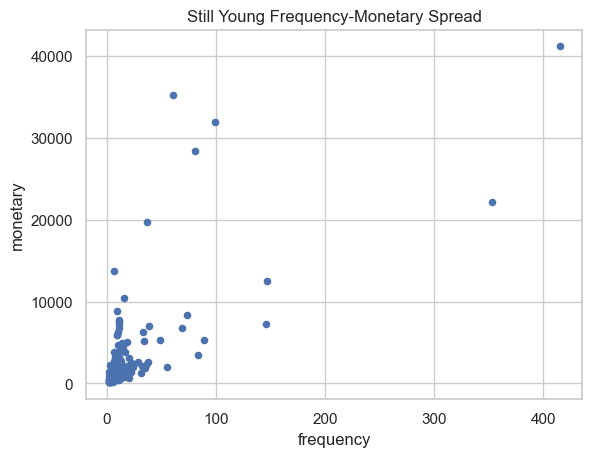

In [77]:
still_young_rfm[['frequency', 'monetary']].plot(kind='scatter', x='frequency', y='monetary', title = "Still Young Frequency-Monetary Spread");


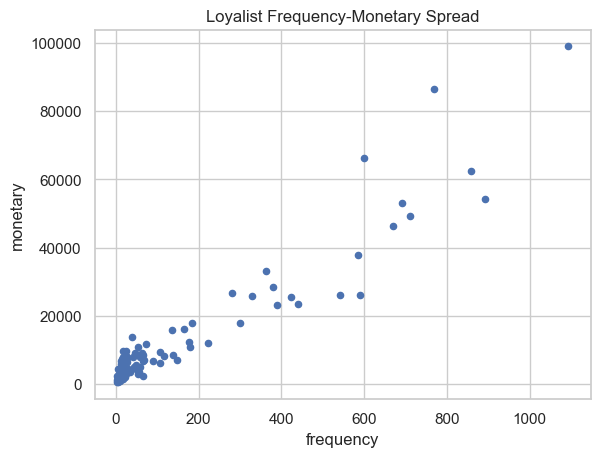

In [78]:
loyalist_rfm[['frequency', 'monetary']].plot(kind='scatter', x='frequency', y='monetary', title = "Loyalist Frequency-Monetary Spread");


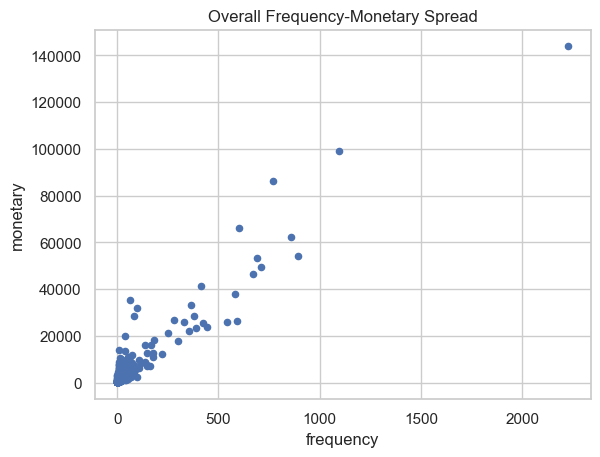

In [79]:
rfm_by_full_name[['frequency', 'monetary']].plot(kind='scatter', x='frequency', y='monetary', title = "Overall Frequency-Monetary Spread");


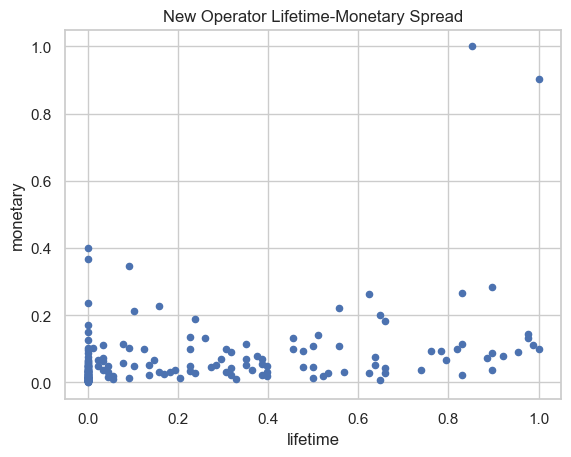

In [80]:
new_rfm_normalized[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "New Operator Lifetime-Monetary Spread");


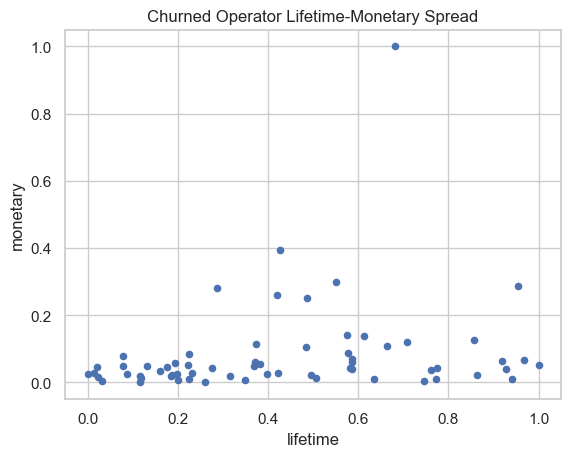

In [81]:
churned_rfm_normalized[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Churned Operator Lifetime-Monetary Spread");


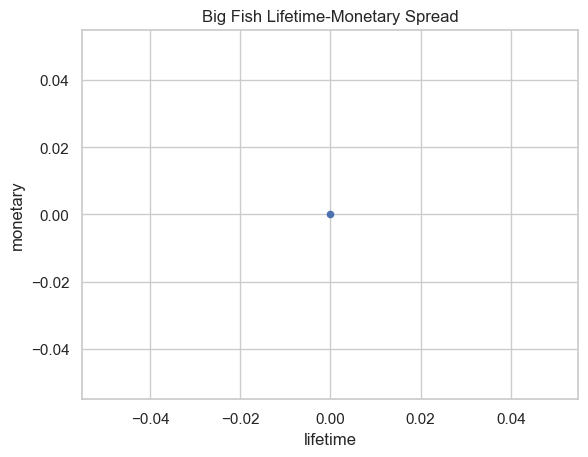

In [82]:
big_fish_rfm_normalized[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Big Fish Lifetime-Monetary Spread");


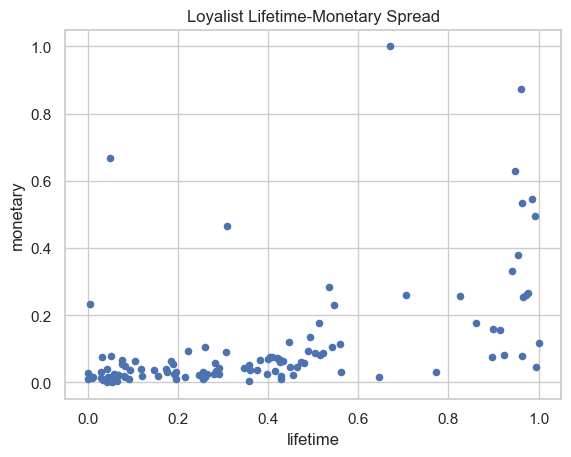

In [83]:
loyalist_rfm_normalized[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Loyalist Lifetime-Monetary Spread");


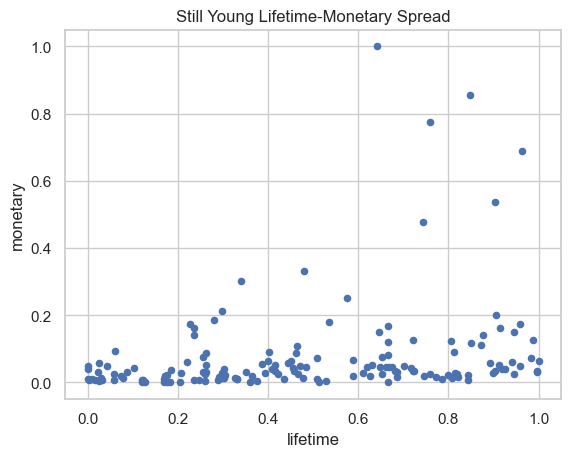

In [84]:
still_young_rfm_normalized[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Still Young Lifetime-Monetary Spread");


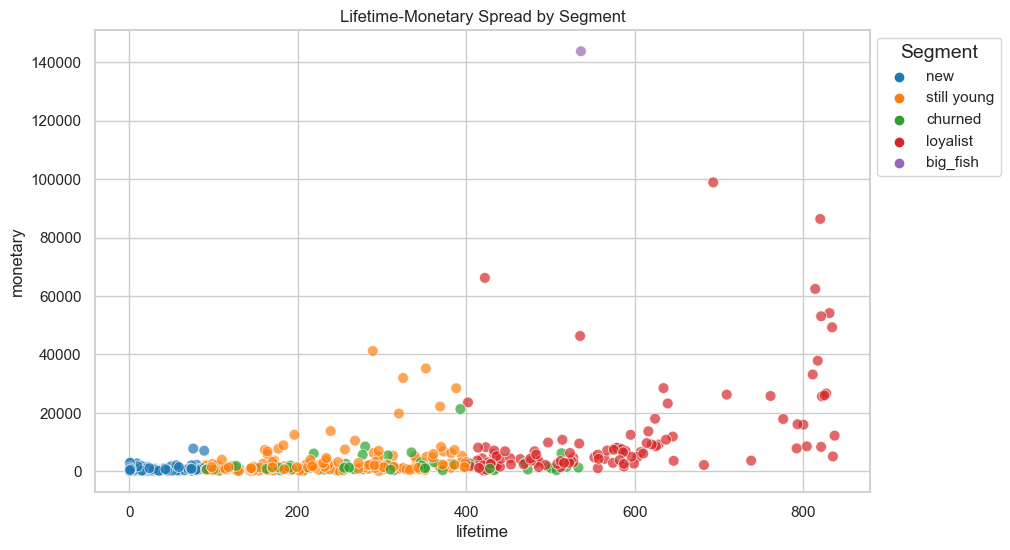

In [87]:

plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=rfm_by_full_name, x='lifetime', y='monetary', hue='seg', palette='tab10', s=60, alpha=0.7, legend='full')
plt.title("Lifetime-Monetary Spread by Segment")

# Legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Segment')  
legend.get_title().set_fontsize('14')  

plt.show()


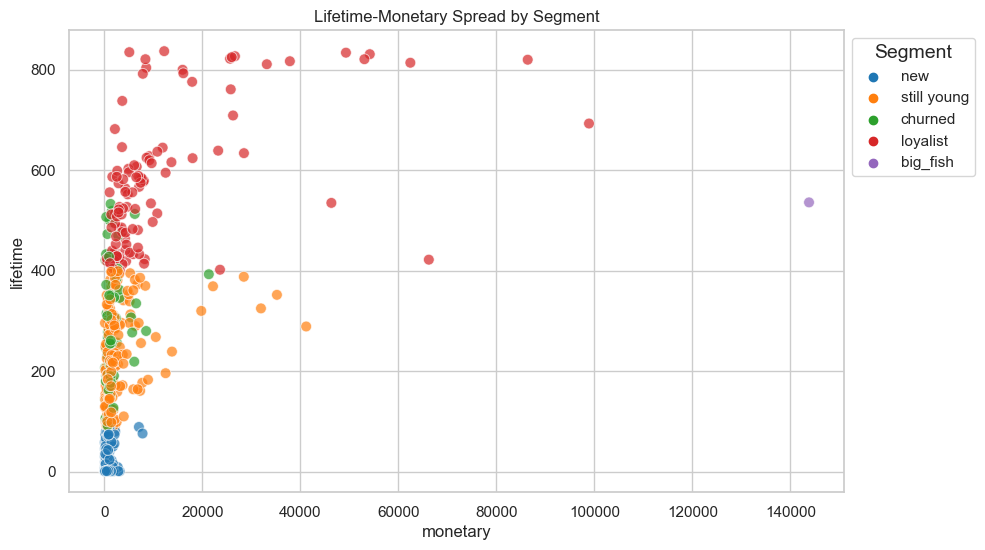

In [96]:

plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=rfm_by_full_name, x='monetary', y='lifetime', hue='seg', palette='tab10', s=60, alpha=0.7, legend='full')
plt.title("Lifetime-Monetary Spread by Segment")

# Legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Segment')
legend.get_title().set_fontsize('14')  

plt.show()

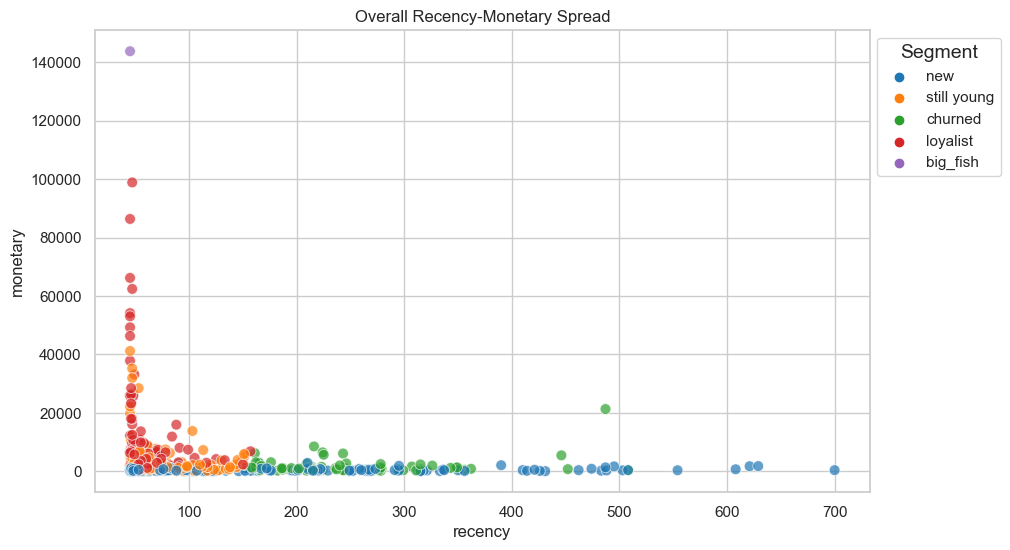

In [88]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=rfm_by_full_name, x='recency', y='monetary', hue='seg', palette='tab10', s=60, alpha=0.7, legend='full')
plt.title("Overall Recency-Monetary Spread")

# Legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Segment') 
legend.get_title().set_fontsize('14')  

plt.show()

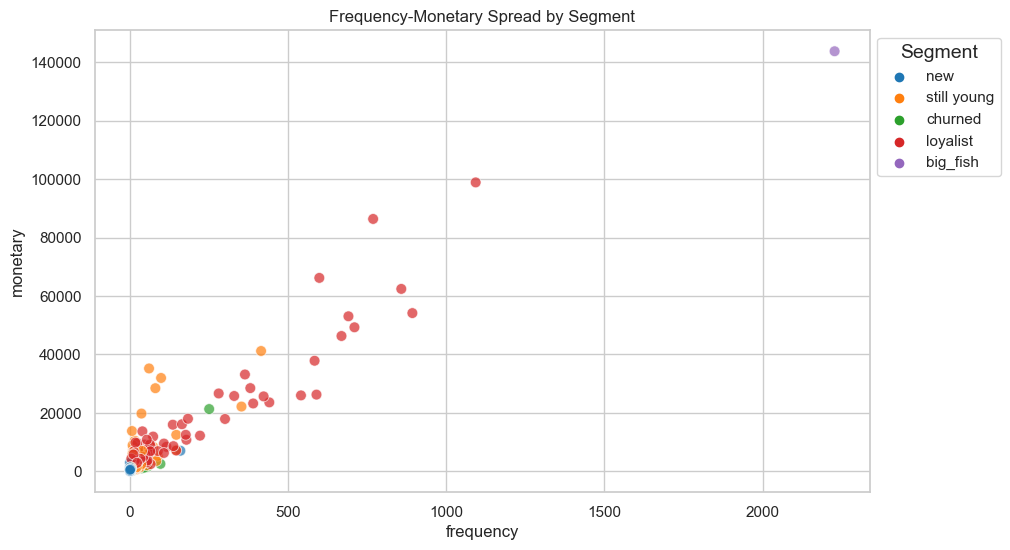

In [89]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=rfm_by_full_name, x='frequency', y='monetary', hue='seg', palette='tab10', s=60, alpha=0.7, legend='full')
plt.title("Frequency-Monetary Spread by Segment")

# Legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Segment') 
legend.get_title().set_fontsize('14')  

plt.show()

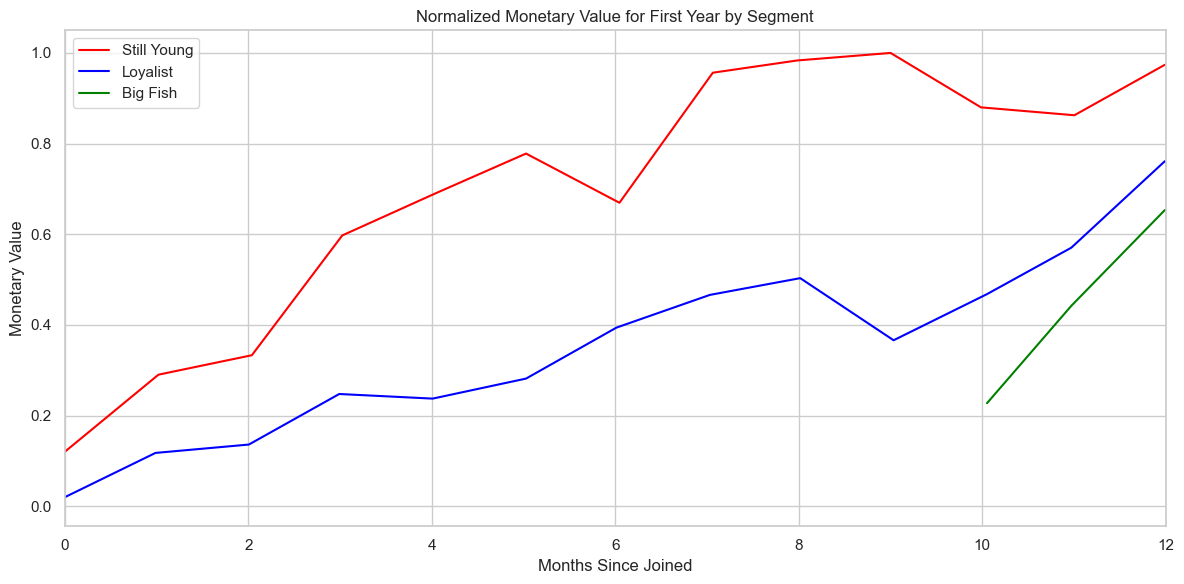

In [92]:
def preprocess(df, base_date):
    df['Month'] = pd.to_datetime(df['Month'])
    df['Months_Since_Joined'] = (df['Month'] - pd.to_datetime(base_date)) / np.timedelta64(1, 'M')
    max_monetary_value = df['Total_final_price'].max()
    df['Normalized_Monetary'] = df['Total_final_price'] / max_monetary_value
    return df

not_blooming_monetary = preprocess(still_young_monetary, '2022-06-30')
loyalist_monetary = preprocess(loyalist_monetary, '2021-03-31')
big_fish_monetary = preprocess(big_fish_monetary, '2021-03-31')

# Plotting
plt.figure(figsize=(12, 6))

sns.lineplot(x=still_young_monetary['Months_Since_Joined'], y=still_young_monetary['Normalized_Monetary'], color='Red', label='Still Young')
sns.lineplot(x=loyalist_monetary['Months_Since_Joined'], y=loyalist_monetary['Normalized_Monetary'], color='Blue', label='Loyalist')
sns.lineplot(x=big_fish_monetary['Months_Since_Joined'], y=big_fish_monetary['Normalized_Monetary'], color='Green', label='Big Fish')

#sns.lineplot(x=still_young_monetary['Months_Since_Joined'], y=still_young_monetary['Total_final_price'], color='Red', label='Not Blooming')
#sns.lineplot(x=loyalist_monetary['Months_Since_Joined'], y=loyalist_monetary['Total_final_price'], color='Blue', label='Loyalist')
#sns.lineplot(x=big_fish_monetary['Months_Since_Joined'], y=big_fish_monetary['Total_final_price'], color='Green', label='Big Fish')


plt.title('Normalized Monetary Value for First Year by Segment')
plt.xlabel('Months Since Joined')
plt.ylabel('Monetary Value')
plt.xlim(0, 12) 
plt.tight_layout()
plt.legend()
plt.show()

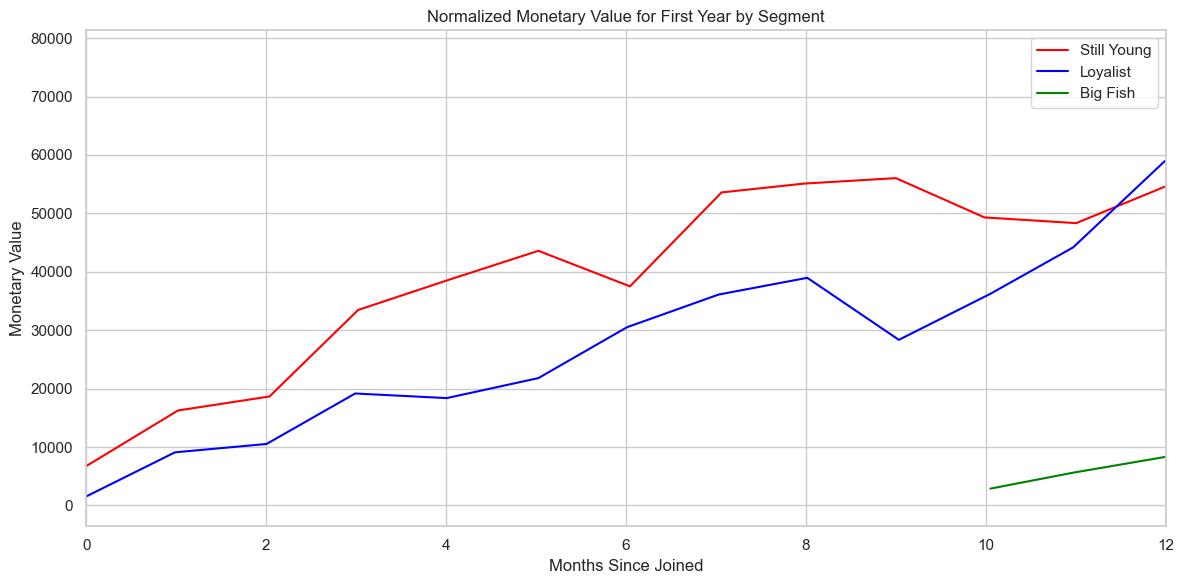

In [93]:
def preprocess(df, base_date):
    df['Month'] = pd.to_datetime(df['Month'])
    df['Months_Since_Joined'] = (df['Month'] - pd.to_datetime(base_date)) / np.timedelta64(1, 'M')
    max_monetary_value = df['Total_final_price'].max()
    df['Normalized_Monetary'] = df['Total_final_price'] / max_monetary_value
    return df

not_blooming_monetary = preprocess(still_young_monetary, '2022-06-30')
loyalist_monetary = preprocess(loyalist_monetary, '2021-03-31')
big_fish_monetary = preprocess(big_fish_monetary, '2021-03-31')

# Plotting
plt.figure(figsize=(12, 6))

#sns.lineplot(x=still_young_monetary['Months_Since_Joined'], y=still_young_monetary['Normalized_Monetary'], color='Red', label='Still Young')
#sns.lineplot(x=loyalist_monetary['Months_Since_Joined'], y=loyalist_monetary['Normalized_Monetary'], color='Blue', label='Loyalist')
#sns.lineplot(x=big_fish_monetary['Months_Since_Joined'], y=big_fish_monetary['Normalized_Monetary'], color='Green', label='Big Fish')

sns.lineplot(x=still_young_monetary['Months_Since_Joined'], y=still_young_monetary['Total_final_price'], color='Red', label='Still Young')
sns.lineplot(x=loyalist_monetary['Months_Since_Joined'], y=loyalist_monetary['Total_final_price'], color='Blue', label='Loyalist')
sns.lineplot(x=big_fish_monetary['Months_Since_Joined'], y=big_fish_monetary['Total_final_price'], color='Green', label='Big Fish')


plt.title('Normalized Monetary Value for First Year by Segment')
plt.xlabel('Months Since Joined')
plt.ylabel('Monetary Value')
plt.xlim(0, 12) 
plt.tight_layout()
plt.legend()
plt.show()

<Axes: xlabel='seg', ylabel='total_customers'>

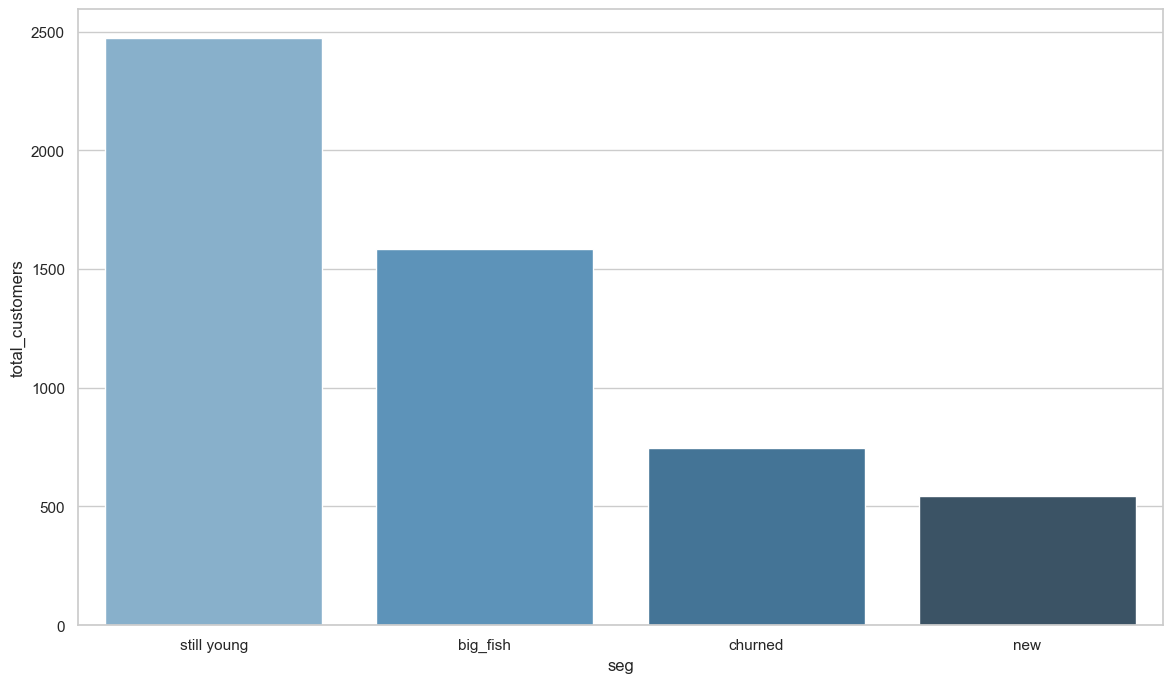

In [94]:
bar_rfm = rfm_by_full_name.groupby('seg')['total_customers'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(14,8))
bar_rfm.drop([0],inplace=True)
sns.barplot(data=bar_rfm,x='seg',y='total_customers',palette='Blues_d')

In [95]:
big_fish_rfm

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity,seg
274,The Yard-US-NY-New York-The Yard Day Pass,45,536,2227,143816.5,1585,0.164038,4.154851,big_fish


In [97]:
churned_rfm.count()

operator           64
recency            64
lifetime           64
frequency          64
monetary           64
total_customers    64
return_rate        64
intensity          64
seg                64
dtype: int64

In [98]:
churned_rfm.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,254.187500,281.390625,15.390625,1920.439063,11.671875,0.167516,0.050661
std,81.328625,126.523179,33.771697,3017.596118,25.042855,0.195802,0.090533
min,158.000000,92.000000,2.000000,151.040000,2.000000,0.000000,0.003945
25%,193.000000,176.500000,4.000000,596.892500,3.000000,0.000000,0.014467
50%,238.500000,264.000000,5.000000,1057.635000,4.000000,0.130252,0.030458
75%,295.250000,364.500000,15.250000,1875.197500,8.000000,0.258929,0.049265
max,508.000000,533.000000,251.000000,21318.040000,187.000000,1.000000,0.638677


In [102]:
churned_rfm.head()

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity,seg
33,Brain Embassy-IL-Tel Aviv-Black Coffee Room - ...,224,315,5,449.49,3,0.333333,0.015873,churned
35,Brain Embassy-IL-Tel Aviv-Daily Open Space - T...,223,519,37,1534.08,31,0.064516,0.071291,churned
37,Brain Embassy-IL-Tel Aviv-Flea Market Room - 1...,307,351,6,1630.90,5,0.200000,0.017094,churned
40,Brain Embassy-IL-Tel Aviv-Innovation Palace,356,174,2,535.04,2,0.000000,0.011494,churned
41,Brain Embassy-IL-Tel Aviv-Peach Room - 16th f...,315,131,3,686.58,3,0.000000,0.022901,churned


In [106]:
churned_rfm[churned_rfm['monetary'] == churned_rfm['monetary'].max()]

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity,seg
129,Mindspace-DE-Munich-Mindspace Daily - Stachus,487,393,251,21318.04,187,0.187166,0.638677,churned


In [107]:
churned_rfm[churned_rfm['recency'] <= 193]

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity,seg
52,Brain Embassy-PL-Warsaw-Brainstorm Room,161,246,2,298.89,2,0.000000,0.008130,churned
87,FoundrSpace-US-CA-Pasadena-1 Desk Office,166,191,4,375.00,3,0.333333,0.020942,churned
89,FoundrSpace-US-CA-Pasadena-Large Conference Room,172,127,5,1162.50,2,0.500000,0.039370,churned
91,FoundrSpace-US-CA-Pasadena-Micro Room 1,182,106,4,225.00,4,0.000000,0.037736,churned
110,M-Dot-IL-Modi'in-Maccabim-Re'ut-Daily Single O...,187,231,7,588.80,7,0.000000,0.030303,churned
307,Urban Place-IL-Tel Aviv-Yavne,161,349,17,1048.91,11,0.181818,0.048711,churned
308,Village Workspaces-US-CA-Los Angeles-Large Con...,187,101,4,1102.50,3,0.333333,0.039604,churned
316,WeWork Israel-IL-Be'er Sheva-Meeting Room 3D,165,470,20,2836.42,16,0.250000,0.042553,churned
334,WeWork Israel-IL-Haifa-Meeting Room 2B,176,346,26,3110.19,17,0.117647,0.075145,churned
348,WeWork Israel-IL-Herzliya-Meeting Room 0C,161,513,23,6203.83,16,0.187500,0.044834,churned


In [108]:
still_young_rfm.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,75.762821,240.487179,20.807692,3340.015385,15.839744,0.155565,0.084080
std,30.957643,91.573238,47.451587,5994.592541,35.491480,0.190154,0.167476
min,45.000000,91.000000,2.000000,120.690000,1.000000,0.000000,0.005698
25%,49.750000,169.250000,6.000000,730.752500,4.000000,0.000000,0.024852
50%,64.000000,232.500000,9.000000,1479.235000,8.000000,0.111111,0.038497
75%,95.250000,315.500000,16.000000,2910.500000,12.000000,0.222222,0.075224
max,157.000000,399.000000,415.000000,41191.000000,311.000000,1.000000,1.435986


In [110]:
top_lifetime_young = still_young_rfm[still_young_rfm['lifetime'] >= 315]

top_lifetime_young.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,74.410256,361.358974,30.974359,5940.835897,23.435897,0.126488,0.085588
std,31.409618,23.801246,58.087723,8888.717473,43.992101,0.118588,0.158318
min,45.000000,320.000000,2.000000,462.070000,2.000000,0.000000,0.005698
25%,50.000000,341.500000,8.500000,1198.840000,7.000000,0.000000,0.024404
50%,62.000000,366.000000,12.000000,2280.000000,9.000000,0.111111,0.034188
75%,89.000000,381.500000,32.500000,5583.500000,19.500000,0.211310,0.091988
max,151.000000,399.000000,353.000000,35219.000000,267.000000,0.400000,0.956640


In [112]:
bottom_recency_young = still_young_rfm[still_young_rfm['recency'] >= 130]

bottom_recency_young.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,143.857143,226.928571,10.928571,2611.392857,9.428571,0.053478,0.056497
std,7.901871,97.109347,8.361673,1913.086820,6.947211,0.080076,0.051804
min,130.000000,101.000000,2.000000,475.000000,2.000000,0.000000,0.010050
25%,137.250000,172.000000,7.250000,1203.750000,6.250000,0.000000,0.024694
50%,144.000000,184.000000,9.000000,1939.500000,8.500000,0.000000,0.041569
75%,151.000000,311.750000,13.250000,3837.500000,9.000000,0.116005,0.057837
max,157.000000,398.000000,36.000000,5911.750000,31.000000,0.222222,0.209302
